# Numpy MNIST

Sam Greydanus | September 2017 | MIT License

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [2]:
class Mnist():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.modes = modes = ['train', 'test']
        trans = transforms.Compose([transforms.ToTensor(),]) # transforms.Normalize((0.1307,), (0.3081,))
        dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
        self.loaders = {k: torch.utils.data.DataLoader(dsets[k], batch_size=batch_size, shuffle=True) for k in modes}

    def next(self, mode='train'):
        X, y = next(iter(self.loaders[mode]))
        return X.resize_(self.batch_size, 28**2).numpy(), y.numpy()

In [3]:
def get_accuracy(model, mnist, nsamples=10000, mode='test'):
    assert mode in mnist.modes, 'incorrect mode supplied'
    assert nsamples >= 10*mnist.batch_size
    pool_size, correct = 0, 0
    total_correct = 0 ; total = 0 ; acc_list = []
    nbatches = int(nsamples/mnist.batch_size)
    for _ in range(nbatches):
        pool_size += mnist.batch_size
        X, y = mnist.next(mode)
        y_hat = model(X)
        correct += sum(y_hat.argmax(axis=1) == y)
        if pool_size > nsamples/10:
            acc_list.append(100*correct/pool_size)
            total_correct += correct
            pool_size, correct = 0, 0
    mean, std = 100*total_correct/(nbatches*mnist.batch_size), np.std(acc_list)
    return mean, std

In [4]:
def forward(X, model):
    # evaluate class scores, [N x K]
    saved = {'X': X.copy()}
    
    h1 = np.dot(X, model['W1']) + model['b1'] # linear layer
    h1[h1<0] = 0 # relu
    saved['h1'] = h1
    
    h2 = np.dot(h1, model['W2']) + model['b2'] # linear layer
    h2[h2<0] = 0 # relu
    saved['h2'] = h2
    
    e = np.exp(h2 - np.amax(h2, axis=1, keepdims=True))
    probs = e / np.sum(e, axis=1, keepdims=True) # softmax cap
    return probs, saved

In [5]:
def backward(y, y_hat, model, saved):
    batch_size = y.shape[0]
    grads = { k : np.zeros_like(v) for k,v in model.items() }
    
    # negative log likelihood
    nll_loss = -np.log(y_hat[range(batch_size),y]).mean()
    y_hat[range(batch_size),y] -= 1 # backwards through softmax
    dh2 = y_hat/batch_size
    
    # second hidden layer
    grads['W2'] = np.dot(saved['h1'].T, dh2)
    grads['b2'] = np.sum(dh2, axis=0, keepdims=True)

    # first hidden layer
    dh1 = np.dot(dh2, model['W2'].T)       # backwards through linear layer
    dh1[saved['h1'] <= 0] = 0              # backwards through relu
    grads['W1'] = np.dot(saved['X'].T, dh1)
    grads['b1'] = np.sum(dh1, axis=0, keepdims=True)
    return nll_loss, grads

In [7]:
def train(model, dataloader, args, horizon=20):
    loss_hist = [] ; acc_hist = []
    rmsprop = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop gradient cache
    for step in range(args['max_steps'] + 1):
        X, y = mnist.next()
        y_hat, saved = forward(X, model)
        
        nll_loss, nll_grads = backward(y, y_hat, model, saved)
        weight_decay_grads = {k : args['weight_decay']*model[k] for k in model.keys()}
        weight_decay_loss = 0.5*args['weight_decay']*np.sum([np.sum(w*w) for w in model.values()])
        
        # parameter update
        grads = {k : -nll_grads[k] + -weight_decay_grads[k] for k in model.keys()}
        for k,v in model.items():
            rmsprop[k] = args['rms_decay'] * rmsprop[k] + (1-args['rms_decay']) * grads[k]**2
            model[k] += args['lr'] * grads[k] / (np.sqrt(rmsprop[k]) + 1e-5)
        
        # bookkeeping
        end = '\r'
        loss_hist += [nll_loss + weight_decay_loss]
        run_loss = sum(loss_hist[-horizon:])/min(horizon, step+1)
        if step % args['test_every'] == 0:
            get_y_hat = lambda X: forward(X, model)[0]
            acc, acc_std = get_accuracy(model=get_y_hat, mnist=mnist)
            acc_hist += [[acc, acc_std]] ; end = '\n'
        print('step {} | run loss {:.4f} | acc {:.2f}% +/- {:.2f}'.format(step, run_loss, acc, acc_std), end=end)
        
    return model, loss_hist, acc_hist

In [8]:
args = {'batch_size': 128, 'lr': 1e-3,
        'rms_decay': 0.98, 'weight_decay': 1e-4,
        'h_size': 256, 'test_every': 500,
        'max_steps': 10000, 'save_dir': './save/'}

model = {}
# first layer
model['W1'] = np.random.randn(28**2, args['h_size']) / np.sqrt(args['h_size']) # Xavier initialization
model['b1'] = np.zeros((1,args['h_size']))
model['W2'] = np.random.randn(args['h_size'],10) / np.sqrt(10)
model['b2'] = np.zeros((1,10))

mnist = Mnist(args['batch_size'])

model, loss_hist, acc_hist = train(model, mnist, args)

step 0 | run loss 3.2900 | acc 27.08% +/- 0.83
step 500 | run loss 0.1431 | acc 88.45% +/- 0.86
step 1000 | run loss 0.1359 | acc 88.65% +/- 0.89
step 1500 | run loss 0.1096 | acc 89.46% +/- 0.57
step 2000 | run loss 0.0840 | acc 90.33% +/- 0.47
step 2500 | run loss 0.0703 | acc 90.35% +/- 0.42
step 3000 | run loss 0.0676 | acc 90.00% +/- 0.55
step 3500 | run loss 0.0776 | acc 90.46% +/- 0.24
step 4000 | run loss 0.0664 | acc 90.03% +/- 0.45
step 4500 | run loss 0.0702 | acc 90.29% +/- 0.35
step 5000 | run loss 0.0765 | acc 90.01% +/- 0.36
step 5500 | run loss 0.0603 | acc 90.11% +/- 0.54
step 6000 | run loss 0.0525 | acc 90.27% +/- 0.38
step 6500 | run loss 0.0675 | acc 90.42% +/- 0.35
step 7000 | run loss 0.0628 | acc 90.56% +/- 0.46
step 7500 | run loss 0.0628 | acc 90.62% +/- 0.45
step 8000 | run loss 0.0554 | acc 90.34% +/- 0.38
step 8500 | run loss 0.0562 | acc 90.09% +/- 0.43
step 9000 | run loss 0.0634 | acc 90.52% +/- 0.30
step 9500 | run loss 0.0578 | acc 90.66% +/- 0.43
step

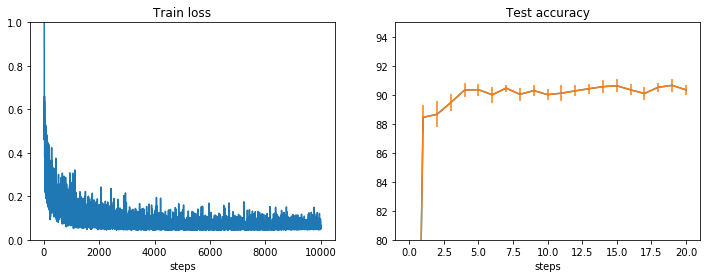

In [9]:
loss_data = np.vstack(loss_hist)
acc_data = np.vstack(acc_hist)

plt.figure(figsize=[12,4])
plt.subplot(1,2,1) ; plt.title("Train loss") ; plt.xlabel("steps")
plt.plot(range(len(loss_hist)), loss_data) ; plt.ylim([0,1])
plt.subplot(1,2,2) ; plt.title("Test accuracy") ; plt.xlabel("steps")
plt.plot(acc_data[:,0]) ; plt.ylim([80,95])
plt.errorbar(range(len(acc_hist)), acc_data[:,0], yerr=acc_data[:,1], errorevery=1)
plt.show()

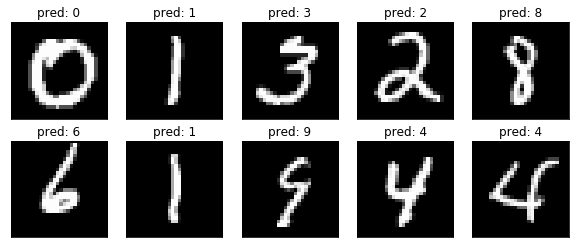

In [10]:
X, y = mnist.next()
y_hat, saved = forward(X, model)
predictions = y_hat.argmax(axis=1)

rows = 2
cols = 5
side = 2
f = plt.figure(figsize=[cols*side,rows*side])
for r in range(rows):
    for c in range(cols):
        img_ix = r*cols + c
        plt.subplot(rows, cols, img_ix+1)
        plt.title("pred: {}".format(predictions[img_ix]))
        plt.imshow(X[img_ix].reshape(28,28), cmap='gray')
        
        f.axes[img_ix].get_xaxis().set_visible(False)
        f.axes[img_ix].get_yaxis().set_visible(False)
plt.show()